In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [7]:
df = pd.read_csv('COVID19_open_line_list.csv')

In [11]:
#df = df[pd.notnull(df['age'])]
df = df[pd.notnull(df['sex'])]
#df = df[pd.notnull(df['country'])]
#df = df[pd.notnull(df['symptoms'])]
df = df[pd.notnull(df['lives_in_Wuhan'])]
df.drop(columns = ['city','province','latitude','longitude','geo_resolution','additional_information','source','sequence_available','outcome','notes_for_discussion','location','admin3','admin2','admin1','country_new','admin_id','data_moderator_initials'])

,ID,age,sex,country,wuhan(0)_not_wuhan(1),date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,chronic_disease_binary,chronic_disease,date_death_or_discharge
248,12097,80-89,male,NaN,1,06.02.2020,09.02.2020,23.02.2020,NaN,no,NaN,No recent travel,NaN,1,hypertension; diabetes,NaN
258,11545,70-79,male,Japan,1,19.02.2020,20.02.2020,21.02.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
276,1771,60-69,male,Japan,1,14.01.2020,25.01.2020,28.01.2020,"chills, cough, joint pain",no,NaN,NaN,no,NaN,NaN,NaN
277,2594,60-69,male,Australia,1,23.01.2020,NaN,29.01.2020,NaN,no,NaN,Wuhan,NaN,NaN,NaN,NaN
278,3021,60-69,male,United States,1,NaN,NaN,30.01.2020,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11910,12053,NaN,female,Spain,1,NaN,NaN,24.02.2020,NaN,no,NaN,Lombardy Italy,NaN,NaN,NaN,NaN
11912,12056,NaN,male,Spain,1,NaN,NaN,25.02.2020,NaN,no,NaN,"Milan, Italy",NaN,NaN,NaN,NaN
11913,12059,NaN,male,Spain,1,NaN,NaN,24.02.2020,NaN,no,NaN,Lombardy Italy,NaN,NaN,NaN,NaN
12371,12541,NaN,Female,China,1,16.02.2020,20.02.2020,24.02.2020,fever,no,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test = df.iloc[:,13]
symptom_set = set()
for row in list(test):
    row = str(row)
    l = row.split(",")
    for symp in l:
        symp = symp.strip()
        if symp == "nan":
            continue
        elif symp not in symptom_set:
            if "fever" in symp or "Fever" in symp:
                symptom_set.add("fever")
            else:
                symptom_set.add(symp)
        else:
            continue
print(symptom_set)

{'sore muscle', 'rhinorrhea', 'sputum', 'anhelation', 'flu-like symptoms', 'discomfort', 'muscle aches', 'rhinorrhoea', 'myalgias', 'sore limbs', 'sneezing', 'fatigue', 'muscle pain', 'lesions on chest radiographs', 'nausea', 'chills', 'weakness', 'dry cough', 'muscle soreness', 'diarrhoea', 'sweating', 'pneumonia', 'expectoration', 'chest pain', 'diarrhea', 'severe dyspnea', 'eventually showed acute left heart failure and acute coronary syndrome', 'dizziness', 'similar to a respiratory infection', 'coughing', 'feeling ill', 'pharynx', 'sneeze', 'cough', 'respiratory symptoms', 'rigor', 'chest tightness', 'respiratory problems', 'conjunctivitis', 'pleuritic chest pain', 'pneumonitis', 'joint pain', 'wheezing', 'sore throat', 'dyspnea', 'runny nose', 'myalgia', 'asymptomatic', 'weak', 'muscular soreness', 'eye irritation', 'fever', 'headache', 'lack of energy', 'shortness of breath', 'pharyngalgia', 'pharyngeal discomfort', 'soreness', 'chest distress', 'vomiting', 'pleural effusion', '

In [13]:
test = df.iloc[:,5]
country_dict = dict()
count = 0
for row in list(test):
    row = str(row)
    if row in country_dict:
        continue
    else:
        country_dict[row] = count
        count+= 1
print(country_dict)

{'nan': 0, 'Japan': 1, 'Australia': 2, 'United States': 3, 'Canada': 4, 'Sweden': 5, 'Germany': 6, 'Finland': 7, 'China': 8, 'Singapore': 9, 'Thailand': 10, 'Vietnam': 11, 'South Korea': 12, 'Spain': 13, 'Cambodia': 14, 'North Macedonia': 15, 'Georgia': 16, 'France': 17, 'Philippines': 18, 'Malaysia': 19, 'Greece': 20, 'Afghanistan': 21, 'Estonia': 22, 'Nepal': 23, 'Italy': 24, 'Croatia': 25, 'Pakistan': 26, 'Romania': 27, 'India': 28}


In [14]:
cleanedData = []
count = 0
Count = 0
for index,row in df.iterrows():
    cur = []
    Count += 1
    '''
    # Clean the age column
    if str(row["age"]).isnumeric():
        #cur.append(int(row["age"]) // 10)
        cur += [0] * (int(row["age"]) // 10) + [1] + (9 - (int(row["age"]) // 10)) * [0]
    else:
        if "-" in row["age"]:
            loc = row["age"].index("-")
            #cur.append(int(row["age"][:loc]) // 10)
            cur += [0] * (int(row["age"][:loc]) // 10) + [1] + (9 - (int(row["age"][:loc]) // 10)) * [0]
        else:
            #cur.append(int(float(row["age"]) // 10))
            cur += [0] * ((int(float(row["age"]))) // 10) + [1] + (9 - ((int(float(row["age"]))) // 10)) * [0]
            
    '''
    # Clean the sex column
    if row["sex"] == "male":
        cur += [1,0]
    else:
        cur += [0,1]
    '''
    # Clean the country
    #cur.append(country_dict[str(row["country"])])
    cur += [0]*(country_dict[str(row["country"])]) + [1] + (26 -country_dict[str(row["country"])]) * [0]
    
    # Clean the Wuhan column, check whether they are citizens in Wuhan, 1 means not Wuhan
    cur.append(row["wuhan(0)_not_wuhan(1)"])
    # Clean the sympton date
    '''
    # Clean the sympton
    temp = str(row["symptoms"]).lower()
    # fever, cough, pneumonitis, fatigue
    # Fever- related
    if "fever" in temp or "headache" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cough related
    if "cou" in temp or "throa" in temp or "dry" in temp or "pharyngeal" in temp or "expectoration" in temp or "flu" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cold related
    if "chill" in temp or "nose" in temp or "nasal" in temp or "sneez" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # pneumonitis related
    if "pneumon" in temp or "respiratory" in temp or "breath" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Muscle or fatigue, physical issue related
    if "fatigue" in temp or "myalgias" in temp or "musc" in temp or "walk" in temp or "chest" in temp or "limbs" in temp or "joint" in temp or "physical" in temp or "energy" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Stomacha related
    if "diarrhoea" in temp or "abdominal" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Other symptom or non-symptom
    if len(temp) > 0 and temp != "nan":
        cur.append(1)
    else:
        cur.append(0)
    
    # Clean the column whether live in Wuhan or have travel relations with Wuhan
    if str(row["lives_in_Wuhan"]).lower() == "nan" or str(row["lives_in_Wuhan"]).lower() == "no" or "wuhan" not in str(row["travel_history_location"]).lower():
        cur.append(0)
    else:
        cur.append(1)
        
    # Clean the target value: date_death_or_discharge
    if str(row["date_death_or_discharge"]).lower() == "nan":
        count += 1
        cur.append(0)
    else:
        cur.append(1)
    cleanedData.append(cur)
    
#print(count,Count)
#print(cleanedData)

In [18]:
print(cleanedData)

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0], [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 

In [19]:
import csv
f = open("NewCleanedConfirmedCase.csv", "a")
fieldnames = ['Male','Female','Fever','Cough','Cold','Pneumonitis','Fatigue','Stomacha','Other Symptoms','Relation with Wuhan','Death or Not']
writer = csv.DictWriter(f, fieldnames=fieldnames)
writer.writeheader()
writer = csv.writer(f)
writer.writerows(cleanedData)
f.close()

In [20]:
df = pd.read_csv("NewCleanedConfirmedCase.csv")

In [21]:
df

,Male,Female,Fever,Cough,Cold,Pneumonitis,Fatigue,Stomacha,Other Symptoms,Relation with Wuhan,Death or Not
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
504,0,1,0,0,0,0,0,0,0,0,0
505,1,0,0,0,0,0,0,0,0,0,0
506,1,0,0,0,0,0,0,0,0,0,0
507,0,1,1,0,0,0,0,0,1,0,0


     Male  Female  Fever  Cough  Cold  Pneumonitis  Fatigue  Stomacha  \
0       1       0      0      0     0            0        0         0   
1       1       0      0      0     0            0        0         0   
2       1       0      0      1     1            0        1         0   
3       1       0      0      0     0            0        0         0   
4       1       0      0      0     0            0        0         0   
..    ...     ...    ...    ...   ...          ...      ...       ...   
504     0       1      0      0     0            0        0         0   
505     1       0      0      0     0            0        0         0   
506     1       0      0      0     0            0        0         0   
507     0       1      1      0     0            0        0         0   
508     0       1      0      0     0            1        0         0   

     Other Symptoms  Relation with Wuhan  
0                 0                    0  
1                 0                  

407/407 [==============================] - 0s 52us/step - loss: 0.1729 - accuracy: 0.9582 - val_loss: 0.2900 - val_accuracy: 0.9216
Epoch 47/300
407/407 [==============================] - 0s 48us/step - loss: 0.1729 - accuracy: 0.9582 - val_loss: 0.2898 - val_accuracy: 0.9216
Epoch 48/300
407/407 [==============================] - 0s 55us/step - loss: 0.1727 - accuracy: 0.9582 - val_loss: 0.2895 - val_accuracy: 0.9216
Epoch 49/300
407/407 [==============================] - 0s 49us/step - loss: 0.1724 - accuracy: 0.9582 - val_loss: 0.2896 - val_accuracy: 0.9216
Epoch 50/300
407/407 [==============================] - 0s 51us/step - loss: 0.1725 - accuracy: 0.9582 - val_loss: 0.2891 - val_accuracy: 0.9216
Epoch 51/300
407/407 [==============================] - 0s 49us/step - loss: 0.1722 - accuracy: 0.9582 - val_loss: 0.2894 - val_accuracy: 0.9216
Epoch 52/300
407/407 [==============================] - 0s 48us/step - loss: 0.1720 - accuracy: 0.9582 - val_loss: 0.2896 - val_accuracy: 0.921

407/407 [==============================] - 0s 62us/step - loss: 0.1668 - accuracy: 0.9582 - val_loss: 0.2865 - val_accuracy: 0.9216
Epoch 103/300
407/407 [==============================] - 0s 60us/step - loss: 0.1667 - accuracy: 0.9582 - val_loss: 0.2865 - val_accuracy: 0.9216
Epoch 104/300
407/407 [==============================] - 0s 53us/step - loss: 0.1666 - accuracy: 0.9582 - val_loss: 0.2868 - val_accuracy: 0.9216
Epoch 105/300
407/407 [==============================] - 0s 50us/step - loss: 0.1666 - accuracy: 0.9582 - val_loss: 0.2872 - val_accuracy: 0.9216
Epoch 106/300
407/407 [==============================] - 0s 56us/step - loss: 0.1665 - accuracy: 0.9582 - val_loss: 0.2866 - val_accuracy: 0.9216
Epoch 107/300
407/407 [==============================] - 0s 55us/step - loss: 0.1664 - accuracy: 0.9582 - val_loss: 0.2869 - val_accuracy: 0.9216
Epoch 108/300
407/407 [==============================] - 0s 58us/step - loss: 0.1663 - accuracy: 0.9582 - val_loss: 0.2871 - val_accuracy:

407/407 [==============================] - 0s 48us/step - loss: 0.1631 - accuracy: 0.9582 - val_loss: 0.2870 - val_accuracy: 0.9216
Epoch 159/300
407/407 [==============================] - 0s 56us/step - loss: 0.1633 - accuracy: 0.9582 - val_loss: 0.2875 - val_accuracy: 0.9216
Epoch 160/300
407/407 [==============================] - 0s 60us/step - loss: 0.1631 - accuracy: 0.9582 - val_loss: 0.2871 - val_accuracy: 0.9216
Epoch 161/300
407/407 [==============================] - 0s 52us/step - loss: 0.1632 - accuracy: 0.9582 - val_loss: 0.2876 - val_accuracy: 0.9216
Epoch 162/300
407/407 [==============================] - 0s 49us/step - loss: 0.1631 - accuracy: 0.9582 - val_loss: 0.2870 - val_accuracy: 0.9216
Epoch 163/300
407/407 [==============================] - 0s 64us/step - loss: 0.1630 - accuracy: 0.9582 - val_loss: 0.2867 - val_accuracy: 0.9216
Epoch 164/300
407/407 [==============================] - 0s 67us/step - loss: 0.1629 - accuracy: 0.9582 - val_loss: 0.2873 - val_accuracy:

407/407 [==============================] - 0s 60us/step - loss: 0.1613 - accuracy: 0.9582 - val_loss: 0.2909 - val_accuracy: 0.9216
Epoch 215/300
407/407 [==============================] - 0s 55us/step - loss: 0.1611 - accuracy: 0.9582 - val_loss: 0.2913 - val_accuracy: 0.9216
Epoch 216/300
407/407 [==============================] - 0s 50us/step - loss: 0.1611 - accuracy: 0.9582 - val_loss: 0.2912 - val_accuracy: 0.9216
Epoch 217/300
407/407 [==============================] - 0s 56us/step - loss: 0.1611 - accuracy: 0.9582 - val_loss: 0.2909 - val_accuracy: 0.9216
Epoch 218/300
407/407 [==============================] - 0s 48us/step - loss: 0.1612 - accuracy: 0.9582 - val_loss: 0.2908 - val_accuracy: 0.9216
Epoch 219/300
407/407 [==============================] - 0s 44us/step - loss: 0.1610 - accuracy: 0.9582 - val_loss: 0.2911 - val_accuracy: 0.9216
Epoch 220/300
407/407 [==============================] - 0s 57us/step - loss: 0.1613 - accuracy: 0.9582 - val_loss: 0.2917 - val_accuracy:

407/407 [==============================] - 0s 54us/step - loss: 0.1600 - accuracy: 0.9582 - val_loss: 0.2940 - val_accuracy: 0.9216
Epoch 271/300
407/407 [==============================] - 0s 53us/step - loss: 0.1599 - accuracy: 0.9582 - val_loss: 0.2945 - val_accuracy: 0.9216
Epoch 272/300
407/407 [==============================] - 0s 55us/step - loss: 0.1599 - accuracy: 0.9582 - val_loss: 0.2946 - val_accuracy: 0.9216
Epoch 273/300
407/407 [==============================] - 0s 51us/step - loss: 0.1599 - accuracy: 0.9582 - val_loss: 0.2941 - val_accuracy: 0.9216
Epoch 274/300
407/407 [==============================] - 0s 58us/step - loss: 0.1599 - accuracy: 0.9582 - val_loss: 0.2939 - val_accuracy: 0.9216
Epoch 275/300
407/407 [==============================] - 0s 54us/step - loss: 0.1598 - accuracy: 0.9582 - val_loss: 0.2943 - val_accuracy: 0.9216
Epoch 276/300
407/407 [==============================] - 0s 53us/step - loss: 0.1601 - accuracy: 0.9582 - val_loss: 0.2949 - val_accuracy:

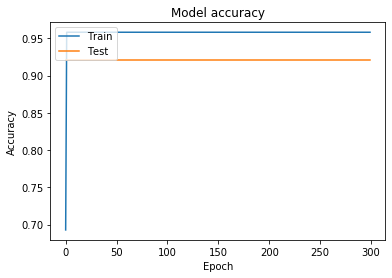

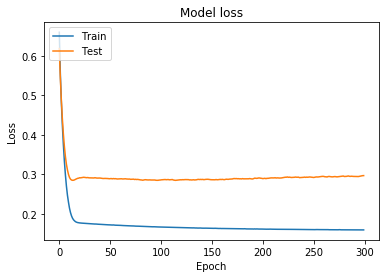

In [28]:

X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
print(X)
print(Y)


def create_model_null():
    model = Sequential()
    model.add(Dense(20,input_dim = 10, activation = 'sigmoid'))
    model.add(Dense(1,activation = 'sigmoid'))
    return model


'''
Model just with backpropagation
'''
def BP(X,Y):
    n = create_model_null()
    n.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = n.fit(X, Y, validation_split=0.2, epochs=300, batch_size=30, verbose=1, shuffle = True)
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
BP(X,Y)

In [23]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) 
# 70% training and 30% test
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9411764705882353
